# Roll decay test parameter sensitivity lock
One of the damping coefficients from the norwegian method is taken as input to the direct estimator, to see if it can predict the same remaining damping coefficient.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 200)
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

import os
from scipy.optimize import curve_fit

from rolldecay.simulation import  simulate
#import rolldecay.parameter_identification as parameter_identification
import rolldecay.read_funky_ascii
import inspect
from rolldecayestimators.direct_estimator import DirectEstimatorD
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [3]:
acii_directory_path = os.path.join(rolldecay.data_path,'project1','Ascii files')
file_names = []
for file_name in os.listdir(acii_directory_path):
    file_names.append(file_name)

In [4]:
pipeline_norwegians = {}

for file_name in file_names:
    
    ascii_file_path = os.path.join(acii_directory_path,file_name)
    df_raw = rolldecay.read_funky_ascii.read(ascii_path=ascii_file_path)[['phi']]
    
    # Exclude tests where roll is not big enough:
    if ((df_raw['phi'].max() < np.deg2rad(1)) |
        (df_raw['phi'].min() > -np.deg2rad(1))):
        continue
    
    

    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.5)
    scaler = ScaleFactorTransformer(scale_factor=29.565)
    cutter = CutTransformer(phi_max=np.deg2rad(8), phi_min=np.deg2rad(0.2))
    offset_transformer = OffsetTransformer()
    norwegian_estimator = NorwegianEstimator()
    
    steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('norwegian_estimator', norwegian_estimator)]
        
    pipeline_norwegian = Pipeline(steps) # define the pipeline object.    
    pipeline_norwegian.fit(X=df_raw)
    pipeline_norwegians[file_name] = pipeline_norwegian

In [5]:
df_norwegian = pd.DataFrame()

for file_name, pipeline_norwegian in pipeline_norwegians.items():
    
    estimator = pipeline_norwegian['norwegian_estimator']
    s = pd.Series(estimator.parameters, name=file_name)
    s['score'] = estimator.score(X=estimator.X)
    s['mean_damping'] = estimator.calculate_average_linear_damping(phi_a=np.deg2rad(4))
    df_norwegian = df_norwegian.append(s)

In [6]:
df_norwegian.sort_values(by='score', ascending=False)

,d,mean_damping,omega0,score,zeta
20084871056k.14.asc,0.050670,0.035927,0.226266,0.999559,0.034426
20084871054k.12.asc,-0.059489,0.020978,0.220638,0.999225,0.022741
20084871054k.07.asc,0.067334,0.016482,0.220048,0.999213,0.014487
20084871055k.15.asc,0.198243,0.034616,0.229429,0.999111,0.028742
20084871054k.06.asc,0.230188,0.016708,0.219980,0.999051,0.009887
20084871052k.12.asc,0.192670,0.049506,0.219319,0.999011,0.043797
20084871056k.15.asc,-0.008767,0.038519,0.226472,0.998958,0.038779
20084871052k.10.asc,-0.060617,0.035491,0.218531,0.998892,0.037287
20084871052k.04.asc,0.162084,0.023578,0.219196,0.998760,0.018776
20084871055k.21.asc,0.218412,0.014913,0.220779,0.998736,0.008441


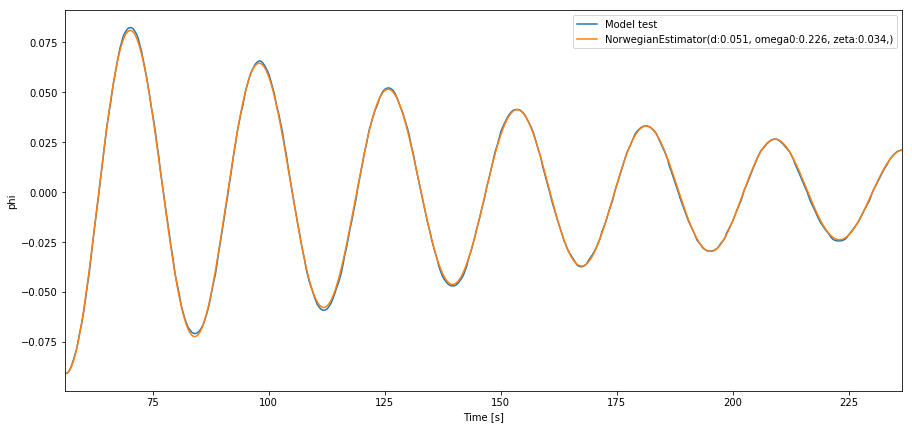

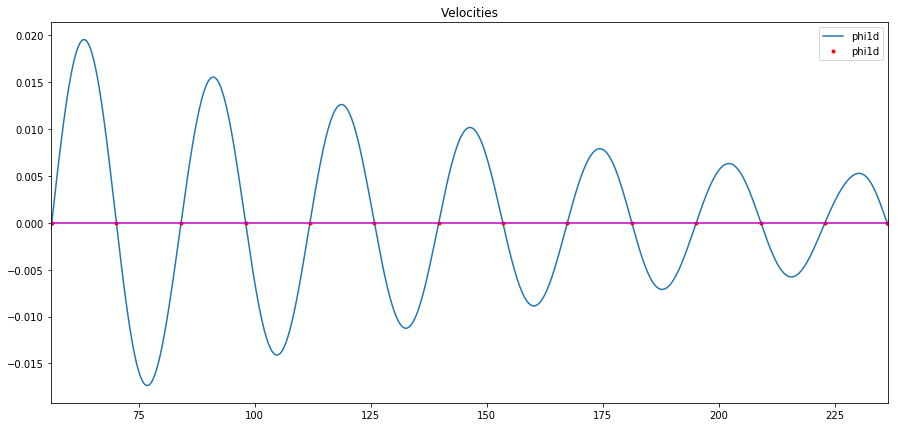

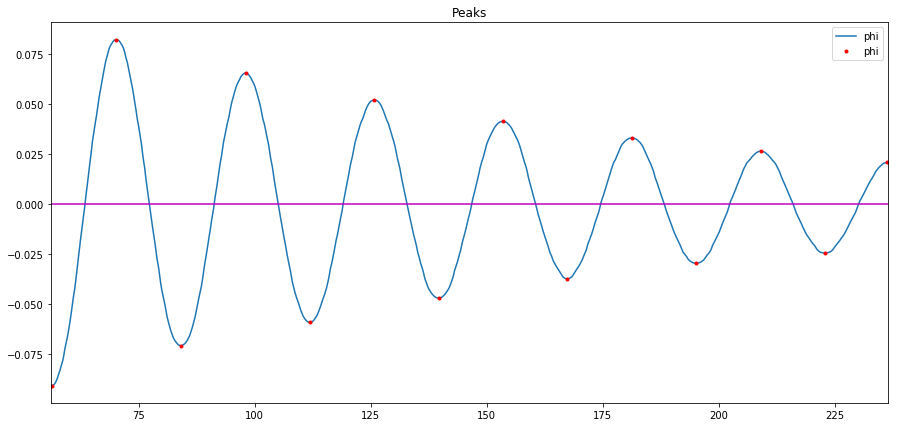

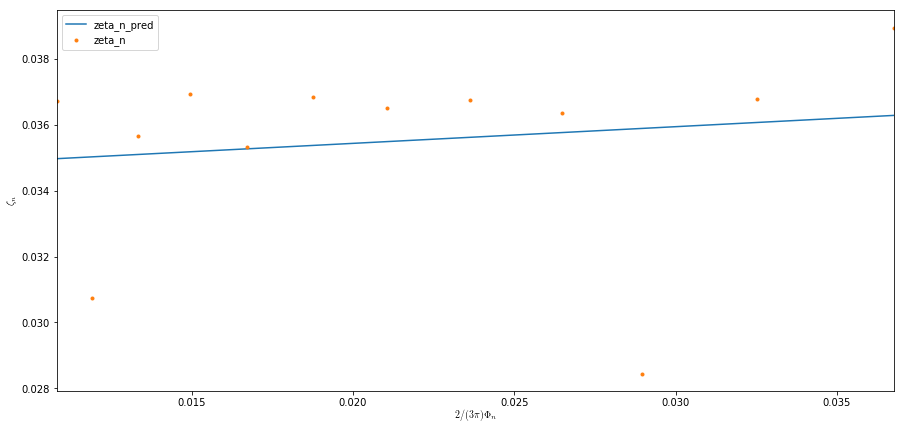

In [7]:
pipeline_norwegian = pipeline_norwegians['20084871056k.14.asc']
estimator = pipeline_norwegian['norwegian_estimator']
estimator.plot_fit()
estimator.plot_velocity()
estimator.plot_peaks()
estimator.plot_damping()

In [8]:
mask = df_norwegian['score'] > 0.99
df_norwegian_good = df_norwegian.loc[mask].copy()

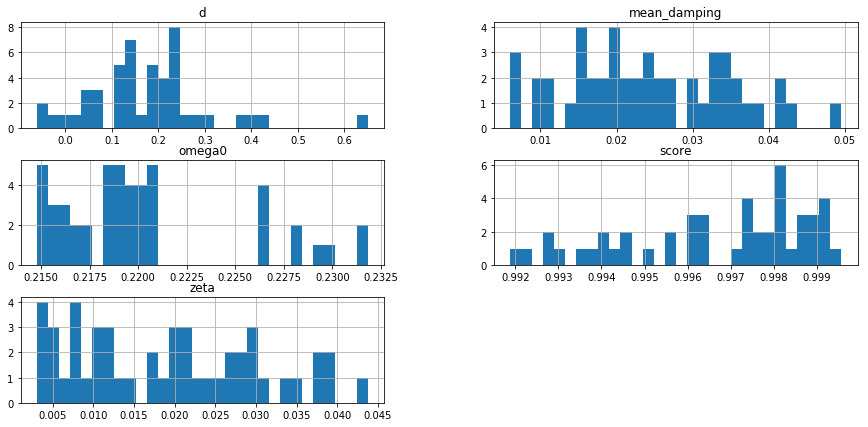

In [9]:
df_norwegian_good.hist(bins=30);

## Direct d
Using the d coefficient from norwegian method as input to the direct method

In [10]:
pipeline_directs = {}

for file_name in file_names:
    
    ascii_file_path = os.path.join(acii_directory_path,file_name)
    df_raw = rolldecay.read_funky_ascii.read(ascii_path=ascii_file_path)[['phi']]
    
    # Exclude tests where roll is not big enough:
    if ((df_raw['phi'].max() < np.deg2rad(1)) |
        (df_raw['phi'].min() > -np.deg2rad(1))):
        continue

    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.5)
    scaler = ScaleFactorTransformer(scale_factor=29.565)
    cutter = CutTransformer(phi_max=np.deg2rad(8), phi_min=np.deg2rad(0.2))
    offset_transformer = OffsetTransformer()
    zeta = df_norwegian.loc[file_name]['zeta']  # "Stealing the d coeff from norwegian solution"
    direct_estimator = DirectEstimatorD(zeta=zeta)
    
    steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('offset_transformer',offset_transformer),
    ('direct_estimator', direct_estimator)]
        
    pipeline_direct = Pipeline(steps) # define the pipeline object.    
    pipeline_direct.fit(X=df_raw)
    pipeline_directs[file_name] = pipeline_direct

In [11]:
df_direct = pd.DataFrame()

for file_name, pipeline_direct in pipeline_directs.items():
    
    estimator = pipeline_direct['direct_estimator']
    s = pd.Series(estimator.parameters, name=file_name)
    s['score'] = estimator.score(X=estimator.X)
    s['mean_damping'] = estimator.calculate_average_linear_damping(phi_a=np.deg2rad(4))
    df_direct = df_direct.append(s)

In [12]:
df_direct.sort_values(by='score', ascending=False)

,d,mean_damping,omega0,score,zeta
20084871054k.07.asc,0.089114,0.017127,0.220048,0.999332,0.014487
20084871056k.14.asc,-0.008125,0.034185,0.226266,0.999296,0.034426
20084871054k.12.asc,-0.050966,0.021230,0.220638,0.999161,0.022741
20084871054k.06.asc,0.235679,0.016870,0.219980,0.999075,0.009887
20084871055k.15.asc,0.188532,0.034328,0.229429,0.999067,0.028742
20084871052k.12.asc,0.188613,0.049386,0.219319,0.999023,0.043797
20084871052k.10.asc,-0.040087,0.036100,0.218531,0.998892,0.037287
20084871052k.04.asc,0.121084,0.022363,0.219196,0.998814,0.018776
20084871056k.15.asc,-0.061503,0.036957,0.226472,0.998729,0.038779
20084871052k.07.asc,0.089179,0.024697,0.219185,0.998673,0.022055


In [13]:
mask = df_direct['score'] > 0.99
df_direct_good = df_direct.loc[mask].copy()

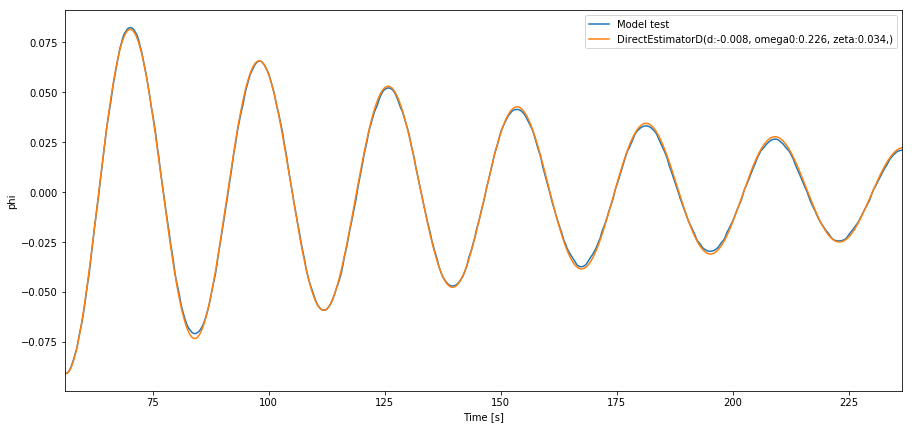

In [14]:
pipeline_direct = pipeline_directs['20084871056k.14.asc']
estimator = pipeline_direct['direct_estimator']
estimator.plot_fit()

### The two methods have similar score but different solutions...

In [15]:
df_comparison = (df_norwegian_good).abs()/df_direct_good.abs()

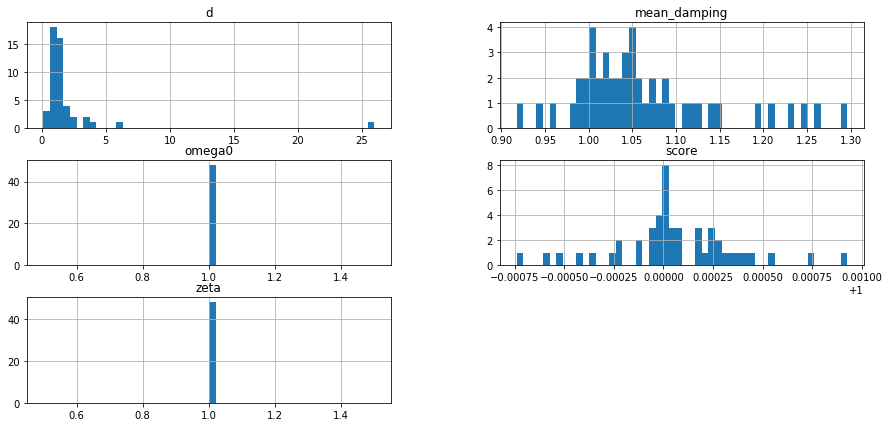

In [16]:
df_comparison.hist(bins=50);